# Monte Carlo Simulation

In [126]:
# Packages used
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import lognorm


Strengths of Monte Carlo Estimation:

- Applicable to any model complexity
- For option pricing, path-dependent options and/or complex payoff structure is handled easily
- Can tackle situations with high dimensionality i.e., many features

Cons of Monte Carlo Estimation:

- In the context of options pricing, it's quite difficult to approach options with early exercise feature (for example American options)
- Accuracy comes at the cost of slow convergence

The objective of Monte Carlo simulation is to calculate an expected value. Let's take the example of simulating an option's underlying stock price at maturity. We start by simulating a large number of "realizations" of the stock price at maturity ($\tau $):

$$S_{\tau}^{(1)}, S_{\tau}^{(2)}, ... , S_{\tau}^{(n)} $$

Note that these outcomes are derived from a function, more specifically they are derived through Geometric Brownian Motion (GBM) implementations:

$$S_{\tau}^{(i)} = S_0e^{(r - \frac{\sigma^2}{2})\tau + \sigma w_{\tau} } $$

$$w_{\tau} \sim N(0, \tau) $$

The realizations will vary given the randomly generated Brownian motion ($w_{\tau}$) component. Let's exemplify this process through 100 simulations of the terminal stock price with the following parameters:

- r = 0.05
- $\sigma$ = 0.30
- $S_0$ = 100
- $\tau$ = 1

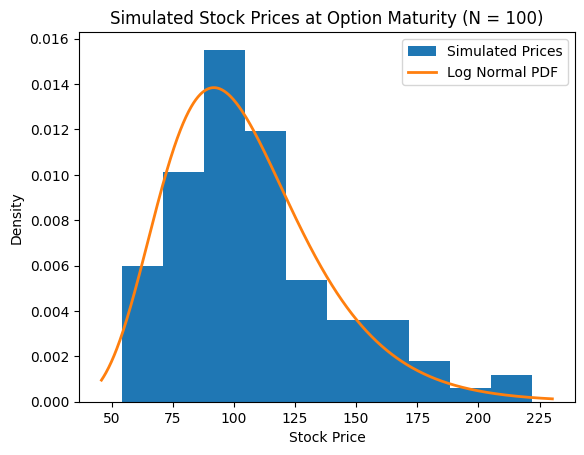

In [151]:
N = 100
r = 0.05
sigma = 0.30
S0 = 100
tau = 1

# Initialize vector of terminal stock prices
ST = np.zeros(N)

# Simulate N standard Brownian motions
wT = np.random.normal(loc = 0, scale = np.sqrt(tau), size = N)

# Simulate N terminal stock prices according to GBM 
for i in range(N):
    ST[i] = S0 * np.exp((r - (sigma**2) / 2) * tau + sigma * wT[i])


# Plot histogram of terminal stock prices
plt.hist(ST, density = True, label = "Simulated Prices")

# Plot log normal PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
scale = S0 * np.exp((r - 0.5 * sigma**2) * tau)
p = lognorm.pdf(x, sigma, scale = scale)
plt.plot(x,p, linewidth = 2, label = "Log Normal PDF")
plt.title("Simulated Stock Prices at Option Maturity (N = 100)")
plt.xlabel("Stock Price")
plt.ylabel("Density")
plt.legend()


We can see that with just 100 simulations the simulated stock price distribution closely resemebles what it should be in actuality i.e., lognormally distributed. Let's see how well the Monte Carlo simulation does with 10,000 simulations.

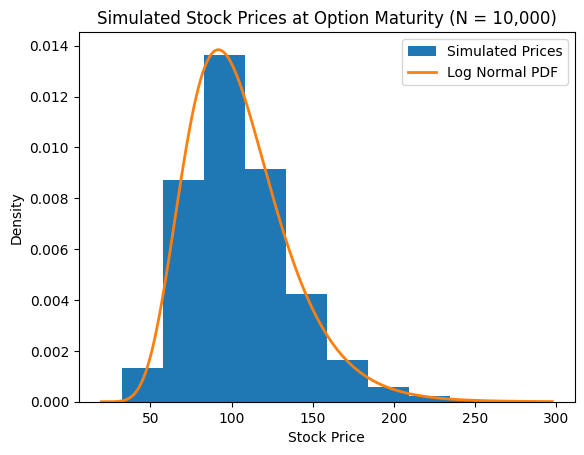

In [152]:
N = 10000
ST = np.zeros(N)
wT = np.random.normal(loc = 0, scale = np.sqrt(tau), size = N)
for i in range(N):
    ST[i] = S0 * np.exp((r - (sigma**2) / 2) * tau + sigma * wT[i])
plt.hist(ST, density = True, label = "Simulated Prices")
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
scale = S0 * np.exp((r - 0.5 * sigma**2) * tau)
p = lognorm.pdf(x, sigma, scale = scale)
plt.plot(x,p, linewidth = 2, label = "Log Normal PDF")
plt.title("Simulated Stock Prices at Option Maturity (N = 10,000)")
plt.xlabel("Stock Price")
plt.ylabel("Density")
plt.legend()

We can see with an increase in simulations, the simulation distribution mimics the true underlying distribution more accurately i.e., there is a convergence in distribution. This is due to the Central Limit Theorem and the Law of Large Numbers:

$$\mathbb{E}[\bar{S_{\tau}}] = \mathbb{E}\bigg[\frac{1}{N} \sum^N_{i=1}S_{\tau}^{(i)}\bigg] =\frac{1}{N} \sum^N_{i=1} \mathbb{E}[S_{\tau}^{(i)}] = \frac{1}{N} \times N \mu = \mu$$

if $\bar{S_{\tau}} $ is an unbiased estimator of $\mu$ and:

$$\mathbb{V}[\bar{S_{\tau}}] = \mathbb{V}\bigg[\frac{1}{N} \sum^N_{i=1}S_{\tau}^{(i)}\bigg] = \bigg(\frac{1}{N} \bigg)^2 \mathbb{V} \bigg[ \sum^N_{i=1}S_{\tau}^{(i)}\bigg] = \bigg(\frac{1}{N} \bigg)^2 \times N  \sigma^2 = \frac{\sigma^2}{N} \underset{N \to \infty}{\longrightarrow} 0$$

if $\bar{S_{\tau}} $ is a consistent estimator of $\mu$. More specifically, the Central Limit Theorem establishes the following:

$$\frac{\bar{S_{\tau}} - \mu}{\sigma / \sqrt{N}} \space \overset{D}{\underset{N \to \infty}{\xrightarrow{\hspace{0.5cm}}}} \space Z \sim N(0,1) $$

i.e., standardizing the simulated random variable (simulated from the correct underlying distribution) will converge in distribution to a standard normal random variable Z. For a large enough N we get:

$$\frac{\bar{S_{\tau}} - \mu}{\sigma / \sqrt{N}} \approx Z \equiv \bar{S_{\tau}} \approx \mu + \frac{\sigma}{\sqrt{N}}  Z $$

where $\mu$ is a first order approximation and $\frac{\sigma}{\sqrt{N}} Z $ is a second order approximation (error term). Note that the second order approximation is necessary given that we can't simply say $\bar{S_{\tau}} = \mu$ due to the computational burden/infeasibility of performing $\infty$ simulations. Therefore, an error term is necessary to quantify how far off we are. This error term is used to construct a confidence interval of the simulated random variable. Given that $\sigma$ is typically unknown, we replace it with the sample estimate (s).

Let's see this all in practice by using Monte Carlo simulation techniques to determine the fair price of a European call option with the same underlying stock parameters as the previous example and a strike price of K = 100. Recall that we can use Black-Scholes to calculate the exact fair price of the option:

$$d_1 = \frac{ln(\frac{S_0}{K}) + (r + \frac{\sigma^2}{2})\tau}{\sigma \sqrt{\tau}} $$

$$d_2 = d_1 - \sigma \sqrt{\tau} $$

$$\text{BS Call Price} = S_0 N(d_1) - K e^{-r \tau} N(d_2)$$

Let's create a function to calculate the "true" price as a comparison for our Monte Carlo approximations:



In [145]:
K = 100
def BS(r, sigma, S0, tau, K):
    d1 = (np.log(S0/K) + (r + (sigma**2)/2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    BS_call = S0 * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    return BS_call


Now that we have the Black-Scholes price, let's use Monte Carlo techniques to see if we derive a similar price through simulations. Note that this is an unbiased simulation ("Exact Simulation") given we are simulating from the correct underlying distribution. Note that we are no longer estimating the terminal stock price and now our Monte Carlo estimator is the European call option price:

$$\text{MC Estimator} = \mathbb{E}[f(S_{\tau})] $$

where: 

$$f(S_{\tau}) = e^{-r \tau} (S_{\tau} - K)^+$$

Let's have the function also output the sample standard deviation as it will be important in the confidence interval calculations:

In [146]:
def MC(r, sigma, S0, tau, K, N):
    ST = np.zeros(N)
    fST = np.zeros(N)
    wT = np.random.normal(loc = 0, scale = np.sqrt(tau), size = N)
    for i in range(N):
        ST[i] = S0 * np.exp((r - (sigma**2) / 2) * tau + sigma * wT[i])
        fST[i] = np.exp(-r * tau) * max((ST[i] - K), 0)
    return (np.mean(fST), np.std(fST))


Next, let's create a function that calculates the confidence interval of the Monte Carlo simulation:

$$CI = \bigg(\mathbb{E}[f(S_{\tau})] - Z_{\alpha} \frac{s}{\sqrt{N}}, \mathbb{E}[f(S_{\tau})] + Z_{\alpha} \frac{s}{\sqrt{N}} \bigg) $$

where s is the sample standard deviation:

$$s = \sqrt{\frac{1}{N} \times \sum^N_{i=1} \bigg(f(S_{\tau}^{(i)}) - \mathbb{E}[f(S_{\tau})] \bigg)^2}$$

In [147]:
def CI(s, mu, alpha, N):
    CI_up = mu + norm.pdf(1 - alpha/2) * (s / np.sqrt(N))
    CI_low = mu - norm.pdf(1 - alpha/2) * (s / np.sqrt(N))
    return (CI_low, CI_up)

Let's now utilize these functions to compare the true Black-Scholes price to an Exact Monte Carlo simulation with 10,000 simulations (N = 10,000) and see if our Monte Carlo estimator lies within the 95% ($\alpha = 0.05$) confidence interval region:

In [148]:
alpha = 0.05
exact_price = BS(r, sigma, S0, tau, K)
MC_sim = MC(r, sigma, S0, tau, K, N)
mu = MC_sim[0]
s = MC_sim[1]
Conf_int = CI(s, mu, alpha, N)
print("BS true price: ", exact_price)
print("MC estimator: ", mu)
print("CI: ", Conf_int)

BS true price:  14.231254785985819
MC estimator:  14.175446527804947
CI:  (14.120003966283363, 14.230889089326531)


Now we have everything we need to show the convergence rate of an Exact Simulation i.e., Monte Carlo simulation where the simulation's distribution assumptions are the same as the true distribution of what we are trying to simulate. Given that we previously showed (changing + to $\pm$ given the symmetry of the distribution):

$$\bar{S_{\tau}} = \mu \pm \frac{\sigma}{\sqrt{N}}  Z  $$

we can rewrite the expression as:

$$\mu = \bar{S_{\tau}} \pm \frac{\sigma}{\sqrt{N}}  Z $$

hence as N increases, we are reducing the error by $\frac{1}{N}$ or in other words Exact Monte Carlo Simulations have a square root convergence. Let's see this in practice in the case of our fictitious European call option


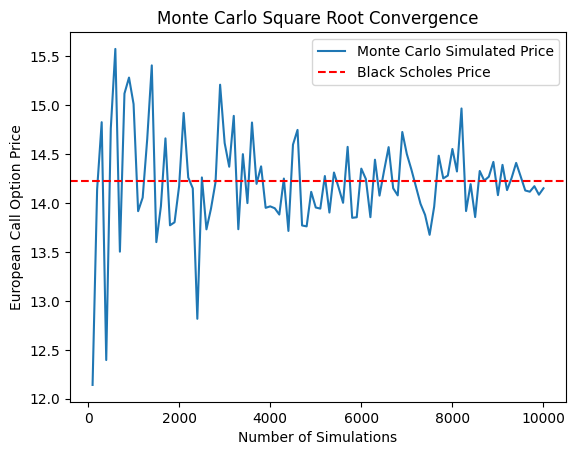

In [153]:
# Grid of N values
N_grid = np.linspace(100, 10000, 100)
N = np.size(N_grid)
STK_i = np.zeros(N)

# Simulating Monte Carlo estimator
for i in range(N):
    STK_i[i] = MC(r, sigma, S0, tau, K, int(N_grid[i]))[0]

# Plotting results
plt.plot(N_grid, STK_i, label = "Monte Carlo Simulated Price")
plt.axhline(y = exact_price, color = "r", linestyle = "--", label = "Black Scholes Price")
plt.xlabel("Number of Simulations")
plt.ylabel("European Call Option Price")
plt.title("Monte Carlo Square Root Convergence")
plt.legend()


## Bias-Variance Tradeoff:

This is a very important concept when discussing Monte Carlo simulations. Bias occurs when the underlying distribution assumptions used in the simulation process are different from what we are actually attempting to simulate. No matter how many simulations we use, even if very large, the Monte Carlo estimator will not converge to the true value ($\mu$). Variance occurs given that as mentioned before, it's impossible to have a sample size of infinity (N = $\infty$) in the application of the Law of Large Numbers. Therefore, we apply the Central Limit Theorem to estimate the variance of the simulated Monte Carlo estimator. Another way to put it in the context of our option pricing example, we can reduce bias in a simulation by putting "more effort" for each simulated stock price path. For example, if we are using Euler Discretization methodologies to simulate the underlying stock price at maturity, the simulation is biased given that the discretization process causes us to simulate from an incorrect distribution. That said, the bias can be reduced by using a finer partition i.e., more time steps. This comes at the cost of extra variance given that variance is reduced by adding more simulations. Monte Carlo simulations involve a level of computational burden we are willing to take on and therefore it's important to choose a good balance between bias and variance.